In [1]:
# train_models.py
import os
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import joblib
import warnings
warnings.filterwarnings("ignore")


In [9]:
# -------------------
# Config
# -------------------
DATASET_PATH = r"D:\Database\EuoroSat\EuroSATallBands"   # <- change to your dataset path
if not os.path.exists(DATASET_PATH):
    raise ValueError(f"Dataset path does not exist: {DATASET_PATH}")
else:
    print("Dataset path OK:", DATASET_PATH)
SAMPLE_PER_CLASS = 500      # limit per class (adjust for memory)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

Dataset path OK: D:\Database\EuoroSat\EuroSATallBands


In [10]:

# -------------------
# Utilities
# -------------------
def extract_features_from_tif(path, compute_indices=True):
    """
    Read a multispectral tif and return feature vector:
    - per-band mean (order B1..Bn)
    """
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        # arr.shape = (bands, H, W)
        # compute mean per band
        band_means = arr.reshape(arr.shape[0], -1).mean(axis=1)
        feats = band_means.tolist()
        # compute NDVI (B8,B4)
        ndvi = (feats[7] - feats[3]) / (feats[7] + feats[3] + 1e-10)
        # NDBI (B11,B8)
        ndbi = (feats[10] - feats[7]) / (feats[10] + feats[7] + 1e-10)
        # NDWI (B3,B8)
        ndwi = (feats[2] - feats[7]) / (feats[2]+  feats[7] + 1e-10)

        feats += [ndvi, ndbi, ndwi]

    return np.array(feats, dtype=np.float32)

      
    return np.array(feats, dtype=np.float32)

In [17]:
# -------------------
# Build dataset (features + labels)
# -------------------
classes = sorted([c for c in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, c))])
print("Classes:", classes)

X_list = []
y_list = []
label_map = {}
for label_id,cls in enumerate(classes):
    folder = os.path.join(DATASET_PATH, cls)
    files = [f for f in os.listdir(folder) if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.TIF')]
    if not files:
        continue
    files = files[:SAMPLE_PER_CLASS]
    label_map[label_id] = cls
    for f in tqdm(files, desc=f"Reading {cls}"):
        path = os.path.join(folder, f)
        try:
            feats = extract_features_from_tif(path, compute_indices=True)
            X_list.append(feats)
            #y_list.append(cls)
            y_list.append(label_id)
        except Exception as e:
            print("Skipping", path, "error:", e)

X = np.vstack(X_list)
y = np.array(y_list)

print("X shape:", X.shape, "y shape:", y.shape,"Label map:", label_map)
joblib.dump(label_map, os.path.join(MODEL_DIR, "label_map.joblib"))
print("LAbel map saved.")


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Reading SeaLake: 100%|██████████| 500/500 [00:13<00:00, 36.55it/s]

X shape: (5000, 16) y shape: (5000,) Label map: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
LAbel map saved.


In [18]:
# -------------------
# Feature cleaning: handle NaN by simple imputation (mean)
# -------------------
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# -------------------
# Scale features
# -------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler + imputer
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))
joblib.dump(imp, os.path.join(MODEL_DIR, "imputer.joblib"))
print("Saved scaler & imputer")


Saved scaler & imputer


In [19]:

# -------------------
# 1) Supervised Random Forest
# -------------------
print("\nTRAINING RandomForest classifier...")
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
print("RandomForest accuracy:", accuracy_score(y_te, pred))
print(classification_report(y_te, pred))
joblib.dump(rf, os.path.join(MODEL_DIR, "rf_classifier.joblib"))
print("Saved RandomForest model.")



TRAINING RandomForest classifier...
RandomForest accuracy: 0.761
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       100
           1       0.95      0.92      0.93       100
           2       0.78      0.79      0.79       100
           3       0.38      0.21      0.27       100
           4       0.76      0.83      0.79       100
           5       0.83      0.86      0.85       100
           6       0.68      0.83      0.75       100
           7       0.59      0.66      0.62       100
           8       0.68      0.73      0.70       100
           9       1.00      1.00      1.00       100

    accuracy                           0.76      1000
   macro avg       0.75      0.76      0.75      1000
weighted avg       0.75      0.76      0.75      1000

Saved RandomForest model.


In [20]:
# =============================================
# 2. Train XGBoost (supervised)
# =============================================

import xgboost as xgb
from xgboost.callback import TrainingCallback
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import joblib
import numpy as np

# --------------------------------------------
# XGBoost Parameters (CPU Optimized)
# --------------------------------------------
params = {
    "objective": "multi:softprob",
    "num_class": len(np.unique(y)),   # number of land-type classes
    "eval_metric": "mlogloss",
    "tree_method": "hist",            # FAST CPU mode
    "max_depth": 12,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}


# Convert to DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dtest  = xgb.DMatrix(X_te,  label=y_te)

# --------------------------------------------
# tqdm Progress Callback
# --------------------------------------------
class TQDMCallback(TrainingCallback):
    def __init__(self, total_rounds):
        self.pbar = tqdm(total=total_rounds, desc="XGBoost Training")

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False

    def after_training(self, model):
        self.pbar.close()
        return model

# --------------------------------------------
# Train
# --------------------------------------------
num_rounds = 200
evals_result = {}  # MUST be defined before calling train

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, "train"), (dtest, "test")],
    evals_result=evals_result,
    verbose_eval=False,
    callbacks=[TQDMCallback(num_rounds)]
)

# --------------------------------------------
# Accuracy
# --------------------------------------------
proba = bst.predict(dtest)
preds = np.argmax(proba, axis=1)

acc = accuracy_score(y_te, preds)
print("XGBoost Accuracy:", acc)

# --------------------------------------------
# Save Model
# --------------------------------------------
joblib.dump(bst, os.path.join(MODEL_DIR, "xgb_land_classifier.joblib"))
print("Saved xgb model.")


XGBoost Training:   0%|          | 0/200 [00:00<?, ?it/s]

XGBoost Training: 100%|██████████| 200/200 [00:06<00:00, 32.96it/s]


XGBoost Accuracy: 0.789
Saved xgb model.


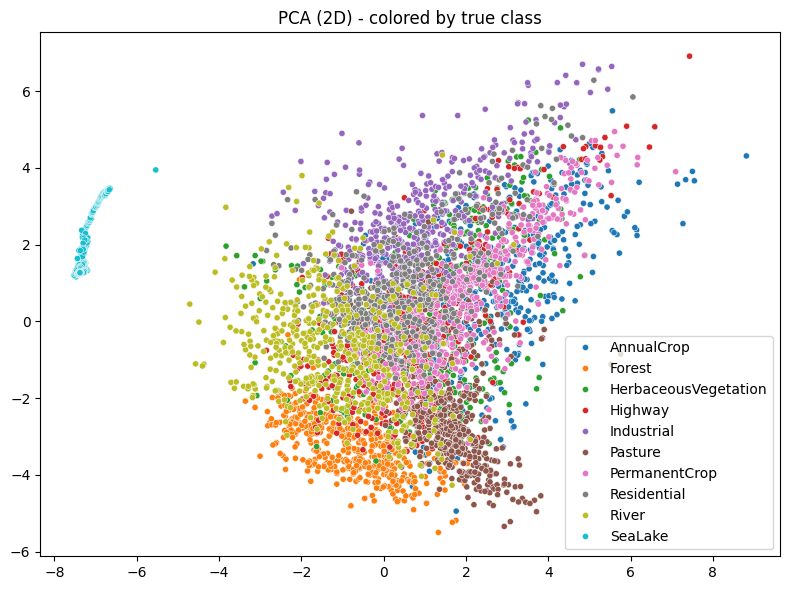

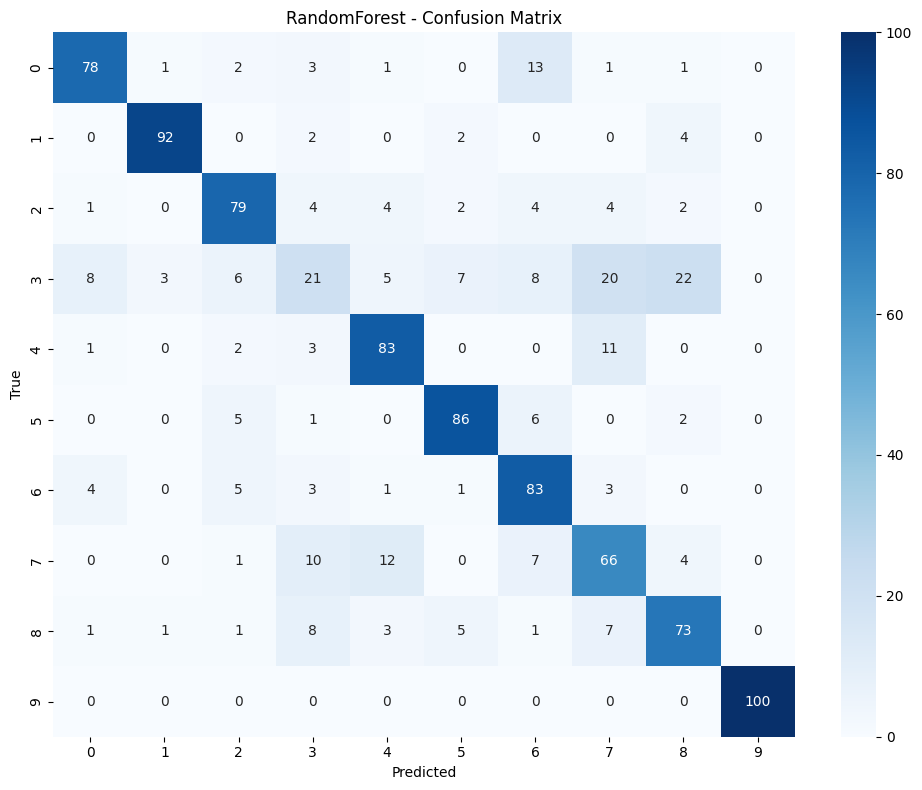

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


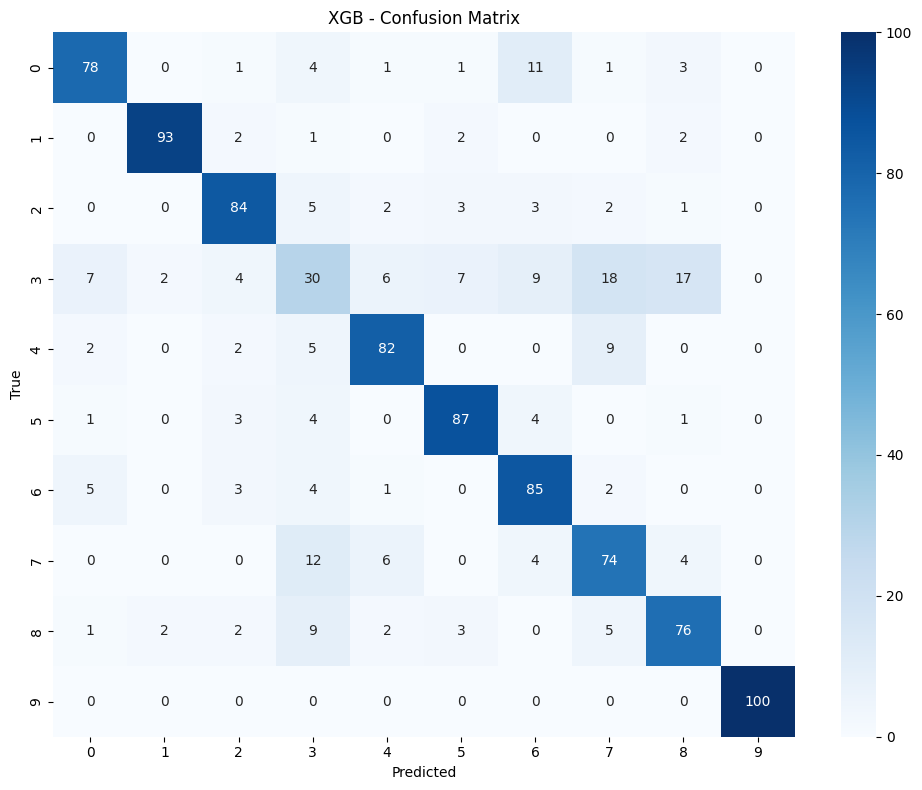

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


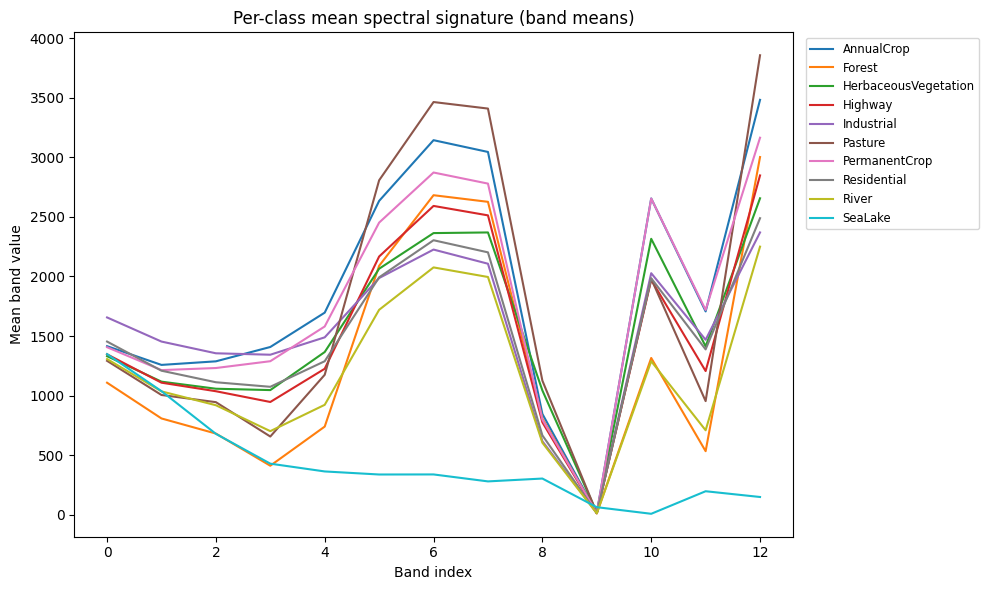

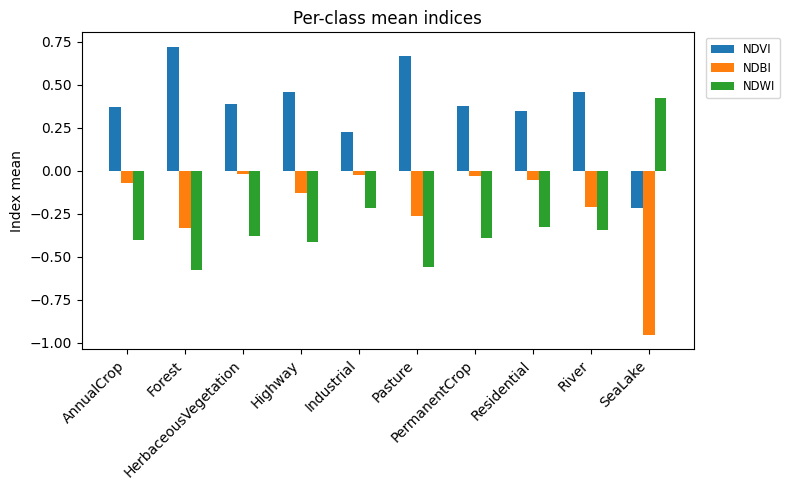

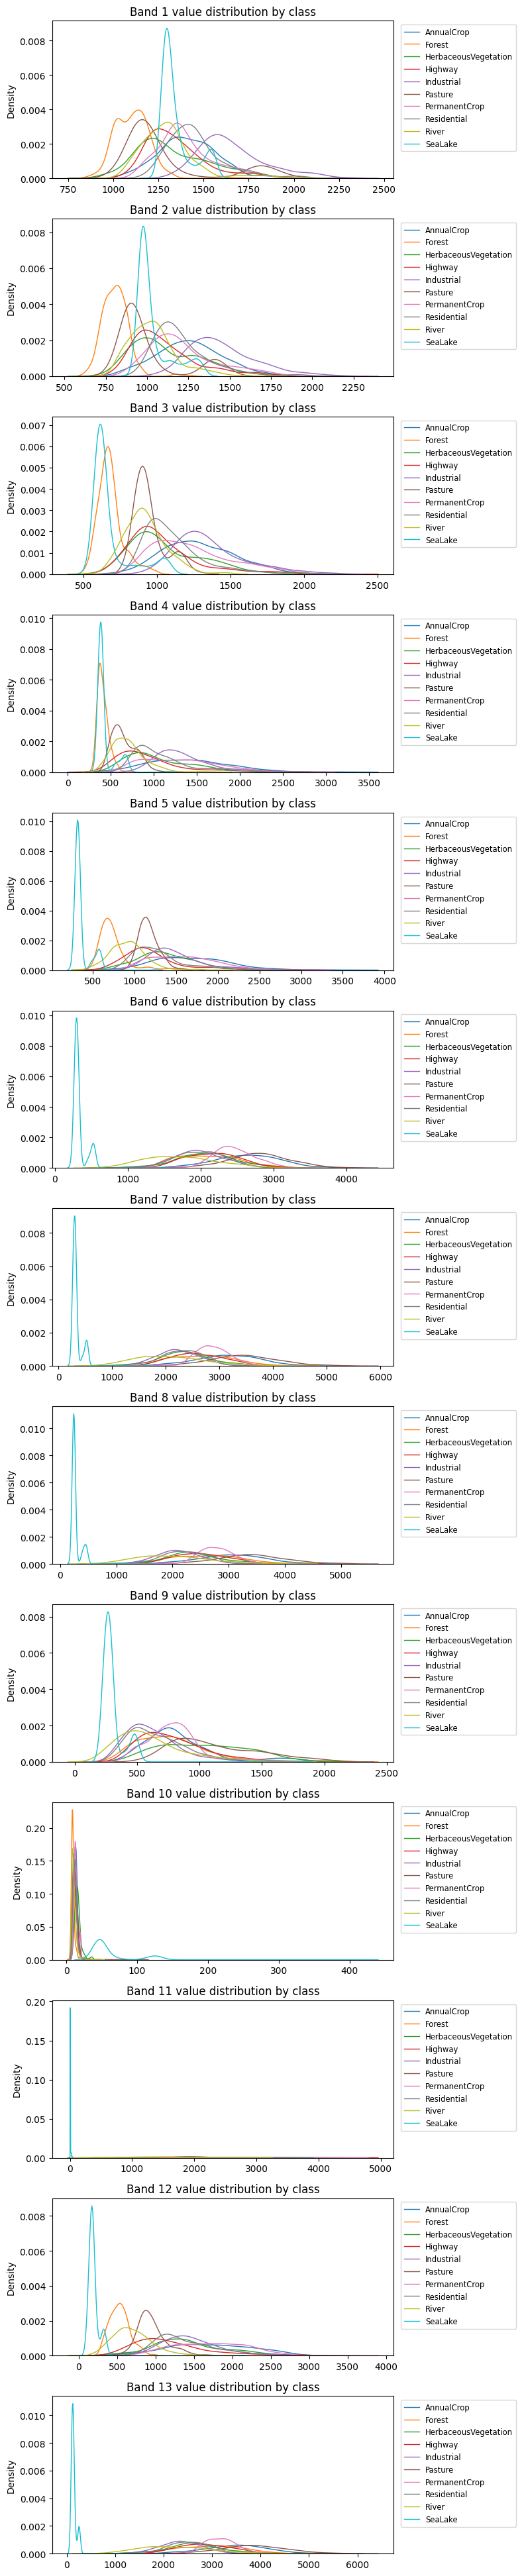

In [21]:
# New visualization cells (append after training / model-save cells)

# Cell: imports & helpers
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import numpy as np

FIG_DIR = os.path.join(MODEL_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def save_fig(fig, name, dpi=150):
    path = os.path.join(FIG_DIR, name)
    fig.tight_layout()
    fig.savefig(path, dpi=dpi)
    display(fig)
    plt.close(fig)

# Cell: PCA scatter (colored by true class and by cluster->class mapping)
# sample to speed up plotting if dataset large
sample_idx = np.arange(X_scaled.shape[0])
if X_scaled.shape[0] > 5000:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(X_scaled.shape[0], size=5000, replace=False)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled[sample_idx])

# map class names to ints/colors
unique_classes = np.array(sorted(list(set(y))))
class_name = np.array(sorted(label_map.values()))
#class_to_int = {c:i for i,c in enumerate(unique_classes)}
#colors = [class_to_int[c] for c in y[sample_idx]]
colors=y[sample_idx]
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=[class_name[i] for i in colors],
                palette="tab10", s=20, ax=ax, legend="full")
ax.set_title("PCA (2D) - colored by true class")
save_fig(fig, "pca_by_true_class.png")


# Cell: Confusion matrix for RF (test set) 
if 'pred' in globals() and 'y_te' in globals():
    cm = confusion_matrix(y_te, pred, labels=unique_classes)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("RandomForest - Confusion Matrix")
    save_fig(fig, "rf_confusion_matrix.png")
print(label_map)
# Cell: Confusion matrix for XGB (test set) 
if 'pred' in globals() and 'y_te' in globals():
    cm3 = confusion_matrix(y_te, preds, labels=unique_classes)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("XGB - Confusion Matrix")
    save_fig(fig, "XGB_confusion_matrix.png")
print(label_map)

# Cell: Per-class spectral signature (mean feature vector)
# assume X columns: band means first, then optional NDVI,NDBI,NDWI (last up to 3)
n_features = X.shape[1]
# heuristic: if features > 6 treat first (n_features-3) as bands else all as bands
n_index_features = 0
if n_features >= 6:
    n_index_features = 3  # NDVI,NDBI,NDWI
n_bands = n_features - n_index_features if n_index_features>0 else n_features
band_idxs = list(range(n_bands))

fig, ax = plt.subplots(figsize=(10,6))
for cls in unique_classes:
    idx = np.where(y == cls)[0]
    if len(idx) == 0:
        continue
    mean_vec = np.nanmean(X[idx, :], axis=0)
    ax.plot(band_idxs, mean_vec[:n_bands], label=label_map[cls], linewidth=1.5)
ax.set_xlabel("Band index")
ax.set_ylabel("Mean band value")
ax.set_title("Per-class mean spectral signature (band means)")
ax.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize="small")
save_fig(fig, "per_class_spectral_signature.png")

# If index features exist, plot them separately
if n_index_features > 0:
    idx_names = ["NDVI","NDBI","NDWI"][:n_index_features]
    fig, ax = plt.subplots(figsize=(8,5))
    for i, name in enumerate(idx_names):
        means = []
        for cls in unique_classes:
            idx = np.where(y == cls)[0]
            means.append(np.nanmean(X[idx, n_bands + i]))
        ax.bar(np.arange(len(unique_classes)) + i*0.2, means, width=0.2, label=name)
    ax.set_xticks(np.arange(len(unique_classes)) + 0.2)
    ax.set_xticklabels(class_name, rotation=45, ha="right")
    ax.set_ylabel("Index mean")
    ax.set_title("Per-class mean indices")
    ax.legend(fontsize="small", bbox_to_anchor=(1.01,1), loc="upper left")
    save_fig(fig, "per_class_indices.png")

# Cell: Per-band histograms for a few representative bands (first 3)
#bands_to_plot = list(range(min(3, n_bands)))
bands_to_plot = list(range(n_bands))
fig, axes = plt.subplots(len(bands_to_plot), 1, figsize=(8, 3*len(bands_to_plot)))
if len(bands_to_plot)==1:
    axes = [axes]
for i, b in enumerate(bands_to_plot):
    ax = axes[i]
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        values = X[idx, b].ravel()
        sns.kdeplot(values, label=label_map[cls], ax=ax, linewidth=1)
    ax.set_title(f"Band {b+1} value distribution by class")
    ax.legend(fontsize="small", bbox_to_anchor=(1.01,1), loc="upper left")
save_fig(fig, "band_histograms.png")